In [2]:
###### load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.preprocessing import binarize
import pickle
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
from mapseq_fxns import sort_by_celltype
# from math import log10
from scipy import stats

# random sample consimment between runs
import random

# import multiple t-tests
from statsmodels.sandbox.stats.multicomp import multipletests

# match edge color to facecolor
import matplotlib.patches

%matplotlib inline

In [3]:
# set-up variables
in_path = '/Volumes/Data/Emily/MAPseq/combined_analysis_M194_M220/'
out_path = '/Volumes/Data/Emily/MAPseq/combined_analysis_M194_M220/output/'

# import metadata
from M194_M220_metadata import *

# import colormaps
from colormaps import purple_cmp, green_cmp, blue_cmp, orange_cmp

#### load data
with open(in_path +'M194_M220_OMC_bin4.pkl', 'rb') as f:
    omc_bin = pickle.load(f)

In [4]:
# seperate by cell type

omc_type = [sort_by_celltype(omc_bin[i]) for i in range(num_samples)]
omc_pt = [(omc_type[i][omc_type[i]['type']==1000]).drop(["type"], axis=1).reset_index(drop=True) for i in range(num_samples)]
omc_it = [(omc_type[i][omc_type[i]['type']==10]).drop(["type"], axis=1).reset_index(drop=True) for i in range(num_samples)]

omc_mm = []
omc_st = []
omc_pt_mm = []
omc_pt_st = []
omc_it_mm = []
omc_it_st = []
mice_mm=[]
mice_st=[]

for i in range(num_samples):
    if metadata.species[i] == 'Mmus':
        omc_mm.append(omc_type[i])
        omc_pt_mm.append(omc_pt[i])
        omc_it_mm.append(omc_it[i])
        mice_mm.append(mice[i])
    else:
        omc_st.append(omc_type[i])
        omc_pt_st.append(omc_pt[i])
        omc_it_st.append(omc_it[i])
        mice_st.append(mice[i])

omc_mm_all = pd.concat(omc_mm)
omc_st_all = pd.concat(omc_st)

In [5]:
def clean_up_data(df_dirty):
    # drop unused areas
    to_drop = ['OB', 'ACAi', 'ACAc', 'HIP']
    dropped = df_dirty.drop(to_drop, axis=1)

    # change RN to bs
    replaced = dropped.rename(columns={'RN':'BS'})

    return replaced


In [6]:
for i in range(len(omc_it_mm)):
    omc_it_mm[i] = clean_up_data(omc_it_mm[i])

for i in range(len(omc_pt_mm)):
    omc_pt_mm[i] = clean_up_data(omc_pt_mm[i])

for i in range(len(omc_it_st)):
    omc_it_st[i] = clean_up_data(omc_it_st[i])

for i in range(len(omc_pt_st)):
    omc_pt_st[i] = clean_up_data(omc_pt_st[i])

# Node degree by cell type

In [7]:
def df_to_nodes(df_list, drop = ["OMCi", "type"], mice=None, species=None):
    """
    Function to turn list of binarized dataframes per animal to dataframe 
    containing node proportions

    df_list = list of binarized dataframes
    drop = list of column names to drop
    mice = list of mouse names
    species = string of species name
    returns dataframe of node proportions
    """

    nodes_list = []
    for i in range(len(df_list)):
        if drop == []:
            int_df = df_list[i]
        else:
            int_df = df_list[i].drop(drop, axis=1)
        nodes = int_df.sum(axis=1)
        node_counts = nodes.value_counts().sort_index()
        node_proportion = node_counts/node_counts.sum()
        df_save = pd.DataFrame(node_proportion, columns=["Normalized Frequency"]).reset_index(names="Node Degree")
        df_save["Species"] = species
        df_save["mouse"] = mice[i]
        nodes_list.append(df_save)

    node_all = pd.concat(nodes_list)

    return node_all


In [8]:
mm_it_nodes = df_to_nodes(omc_it_mm, drop=["OMCi"], mice=mice_mm, species="MMus")
st_it_nodes = df_to_nodes(omc_it_st, drop=["OMCi"], mice=mice_st, species="STeg")
mm_pt_nodes = df_to_nodes(omc_pt_mm, drop=["OMCi"], mice=mice_mm, species="MMus")
st_pt_nodes = df_to_nodes(omc_pt_st, drop=["OMCi"], mice=mice_st, species="STeg")

# Plotting by node!


In [9]:
def dot_bar_plot(df, title):
    """
    Function to take pandas dataframe and plot individual values and mean/sem values
    Intent to use for plotting nodes by frequency (in fraction of neurons)

    Args:
        df (pandas.core.frame.DataFrame): pandas dataframe where rows are nodes and columns are:
         'Node Degreee', 'Normalized Frequency', 'Species', and 'mouse'
         - See output of df_to_nodes
        title (str): plot title
    """
    sns.stripplot(df, x="Node Degree", y="Normalized Frequency", hue="Species", dodge=True, jitter=False, size=3)
    t_ax = sns.barplot(df, x="Node Degree", y="Normalized Frequency", hue="Species", errorbar="se", errwidth=1)
    for patch in t_ax.patches:
        clr = patch.get_facecolor()
        patch.set_edgecolor(clr)
        patch.set_facecolor((0,0,0,0))
    plt.setp(t_ax.patches, linewidth=1)
    plt.title(title, size=18)

    return(plt.show())
    

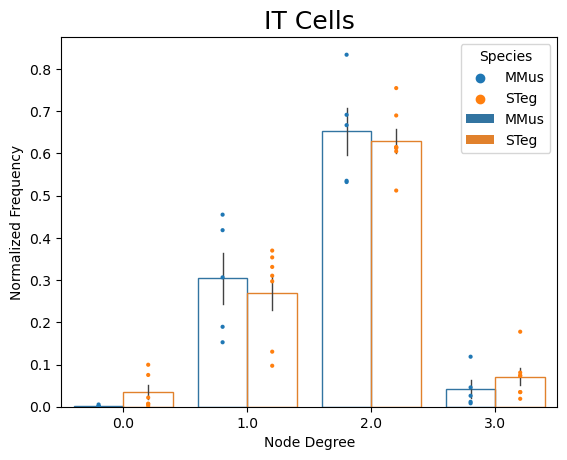

In [10]:
plot = pd.concat([mm_it_nodes, st_it_nodes])
dot_bar_plot(plot, "IT Cells")

In [11]:
def node_to_nand(node_df, cutoff=5):
    """
    Take node dataframe and return node categories so higher degrees are in one (+) category

    Args:
        node_df (pandas dataframe): Node dataframe columns = ['Node Degree', 'Normalized Frequency', 'Species', 'mouse']
        cutoff (int, optional): highest node degree to display, Defaults to 5.
    """
    idxn = node_df['Node Degree'] > cutoff
    node_dfand = node_df[~idxn].reset_index(drop=True) # take copy of node 1...cutoff
    # change node degrees to integers
    node_dfand['Node Degree'] = node_dfand['Node Degree'].astype(np.int16)

    mice = node_df['mouse'].unique()
    end = str(cutoff+1) + '+'
    species = node_df['Species'].values[0]

    for i in range(len(mice)):
        idxm = node_df[idxn]['mouse'] == mice[i]
        int = node_df[idxn][idxm]
        int_sum = int['Normalized Frequency'].sum()
        node_dfand.loc[len(node_dfand.index)] = [end, int_sum, species, mice[i]]

    node_dfand['Node Degree'] = node_dfand['Node Degree'].astype(str)
    node_dfand = node_dfand.sort_values(by=['Node Degree'])

    return node_dfand

In [12]:
# change node 6 to 6+
mm_pt_nodes_5and = node_to_nand(mm_pt_nodes)
st_pt_nodes_5and = node_to_nand(st_pt_nodes)


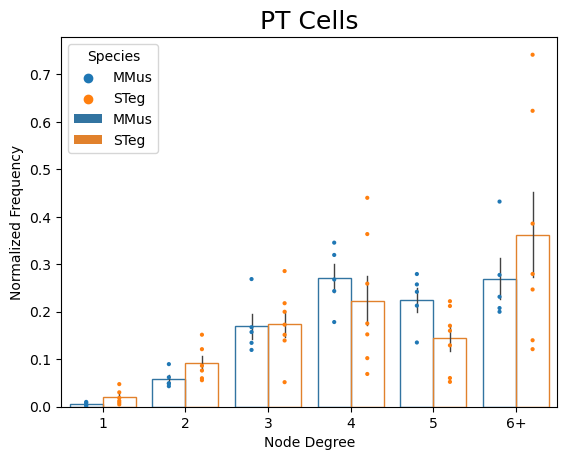

In [13]:
plot = pd.concat([mm_pt_nodes_5and, st_pt_nodes_5and])
dot_bar_plot(plot, "PT Cells")

# Look at AUD neurons

In [14]:
def subset_neurons(df_list, area='AUD'):
    """subset neurons that project to a certain area

    Args:
        df_list (list): list of dataframes of neurons x areas
        area (str, optional): Area to be isolated. Defaults to 'AUD'.
    """
    area_isolate = []
    for i in range(len(df_list)):
        area_idx = df_list[i][area] == 1
        area_isolate.append(df_list[i][area_idx])
    return area_isolate


In [15]:
# seperate AUD neurons
aud_it_mm = subset_neurons(omc_it_mm)
aud_it_st = subset_neurons(omc_it_st)
aud_pt_mm = subset_neurons(omc_pt_mm)
aud_pt_st = subset_neurons(omc_pt_st)

In [16]:
# calculate degrees for aud cells
aud_mm_it_nodes = df_to_nodes(aud_it_mm, drop=["OMCi"], mice=mice_mm, species="MMus")
aud_st_it_nodes = df_to_nodes(aud_it_st, drop=["OMCi"], mice=mice_st, species="STeg")
aud_mm_pt_nodes = df_to_nodes(aud_pt_mm, drop=["OMCi"], mice=mice_mm, species="MMus")
aud_st_pt_nodes = df_to_nodes(aud_pt_st, drop=["OMCi"], mice=mice_st, species="STeg")

aud_mm_pt_nodes_5and = node_to_nand(aud_mm_pt_nodes)
aud_st_pt_nodes_5and = node_to_nand(aud_st_pt_nodes)

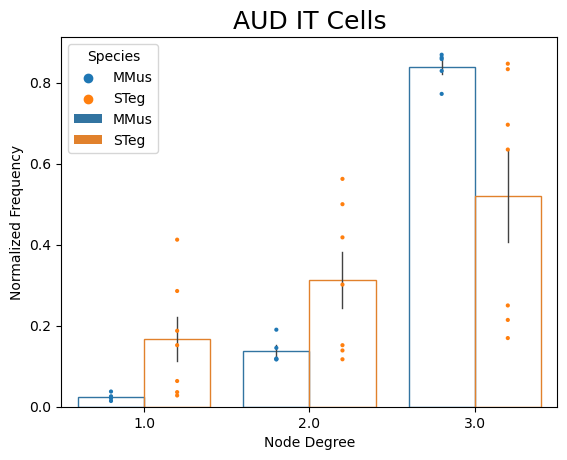

In [17]:
plot = pd.concat([aud_mm_it_nodes, aud_st_it_nodes])
dot_bar_plot(plot, "AUD IT Cells")

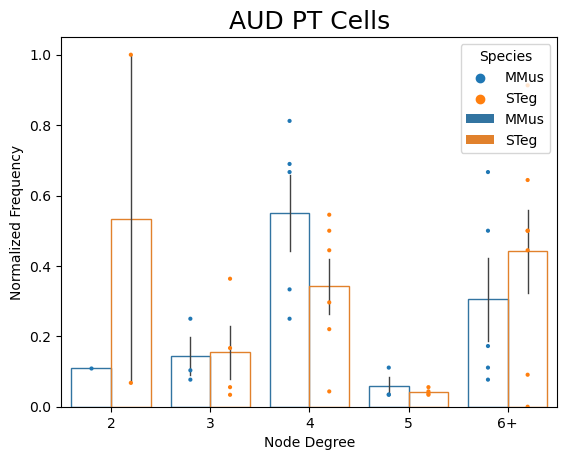

In [18]:
plot = pd.concat([aud_mm_pt_nodes_5and, aud_st_pt_nodes_5and])
dot_bar_plot(plot, "AUD PT Cells")


In [19]:
def print_nums(df_list, species='MMus', mice=mice_mm, area='AUD'):
    """take in list of dataframes w/ subsetted neurons used to calculate nodes, return neuron numbers in nice dataframe fomat

    Args:
        df_list (list): list of dataframes of neuron x area for subsetted area
    """

    neuron_nums = pd.DataFrame()
    mice = pd.Series(mice)
    nums = []
    for i in range(len(df_list)):
        nums.append(df_list[i].shape[0])

    neuron_nums['Species'] = [species]*len(df_list)
    neuron_nums['Mouse'] = mice
    neuron_nums[area + ' neurons'] = nums
    return neuron_nums     

In [20]:
print('OMCi TO AUD NEURONS')
display(print_nums(aud_pt_st, species='STeg', mice=mice_st))
display(print_nums(aud_pt_mm))

OMCi TO AUD NEURONS


,Species,Mouse,AUD neurons
0,STeg,STM1,11
1,STeg,STM2,1
2,STeg,STF3,2
3,STeg,STF4,18
4,STeg,STM5,23
5,STeg,STF6,54
6,STeg,STM7,59


,Species,Mouse,AUD neurons
0,MMus,MMM1,3
1,MMus,MMF2,29
2,MMus,MMF3,9
3,MMus,MMM4,117
4,MMus,MMF5,4


Text(0.5, 1.0, 'AUD PT Cells')

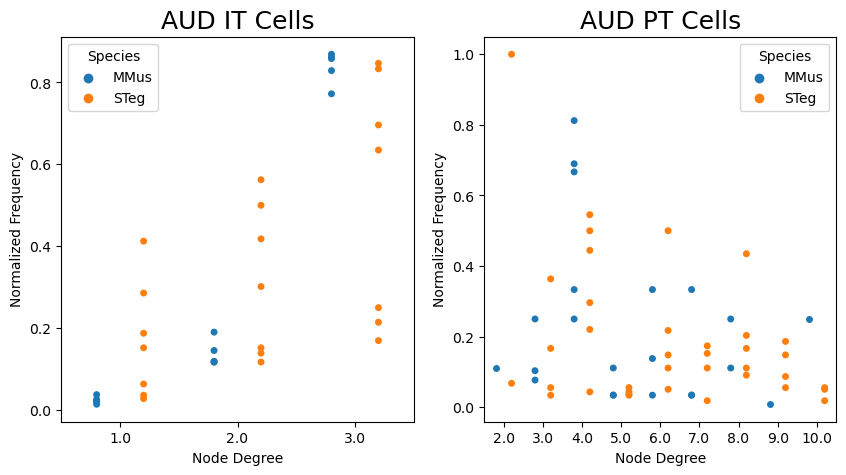

In [21]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

# make dot plots for degrees
plot = pd.concat([aud_mm_it_nodes, aud_st_it_nodes])
sns.stripplot(plot, x="Node Degree", y="Normalized Frequency", hue="Species", dodge=True,
              jitter = False, ax=axs[0])
axs[0].set_title("AUD IT Cells", size=18)

# make dot plots for degrees
plot = pd.concat([aud_mm_pt_nodes, aud_st_pt_nodes])
sns.stripplot(plot, x="Node Degree", y="Normalized Frequency", hue="Species", dodge=True,
              jitter = False, ax=axs[1])
axs[1].set_title("AUD PT Cells", size=18)

Text(0.5, 1.0, 'AUD PT Cells')

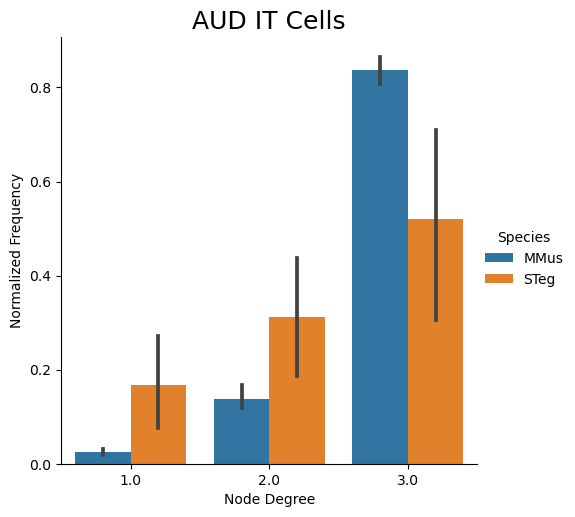

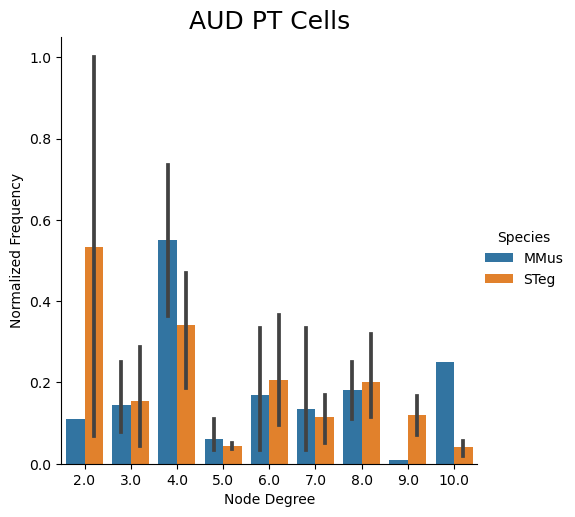

In [22]:
# make dot plots for degrees
plot = pd.concat([aud_mm_it_nodes, aud_st_it_nodes])
sns.catplot(plot, x="Node Degree", y="Normalized Frequency", hue="Species", kind="bar")
plt.title("AUD IT Cells", size=18)

# make dot plots for degrees
plot = pd.concat([aud_mm_pt_nodes, aud_st_pt_nodes])
sns.catplot(plot, x="Node Degree", y="Normalized Frequency", hue="Species", kind="bar")
plt.title("AUD PT Cells", size=18)

# PAG

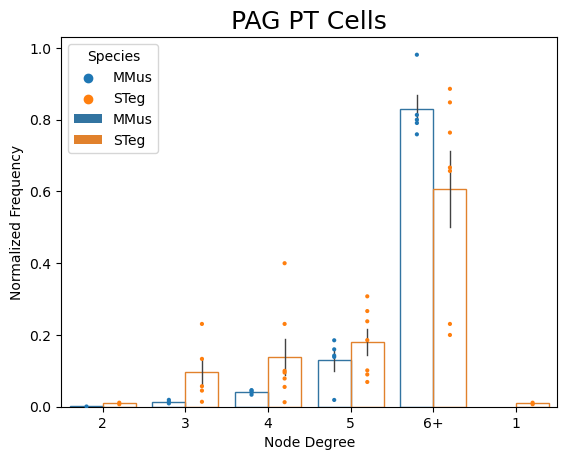

OMCi TO PAG NEURONS


,Species,Mouse,PAG neurons
0,STeg,STM1,21
1,STeg,STM2,13
2,STeg,STF3,15
3,STeg,STF4,70
4,STeg,STM5,79
5,STeg,STF6,89
6,STeg,STM7,145


,Species,Mouse,PAG neurons
0,MMus,MMM1,25
1,MMus,MMF2,209
2,MMus,MMF3,108
3,MMus,MMM4,53
4,MMus,MMF5,1095


In [28]:
# seperate PAG neurons - only find in pt neurons
pag_pt_mm = subset_neurons(omc_pt_mm, area='PAG')
pag_pt_st = subset_neurons(omc_pt_st, area='PAG')


# calculate degrees for pag cells
pag_mm_pt_nodes = df_to_nodes(pag_pt_mm, drop=["OMCi"], mice=mice_mm, species="MMus")
pag_st_pt_nodes = df_to_nodes(pag_pt_st, drop=["OMCi"], mice=mice_st, species="STeg")

pag_mm_pt_nodes_5and = node_to_nand(pag_mm_pt_nodes)
pag_st_pt_nodes_5and = node_to_nand(pag_st_pt_nodes)

# plot
plot = pd.concat([pag_mm_pt_nodes_5and, pag_st_pt_nodes_5and])
dot_bar_plot(plot, "PAG PT Cells")

print('OMCi TO PAG NEURONS')
display(print_nums(pag_pt_st, species='STeg', mice=mice_st, area='PAG'))
display(print_nums(pag_pt_mm, area='PAG'))

# OMCc

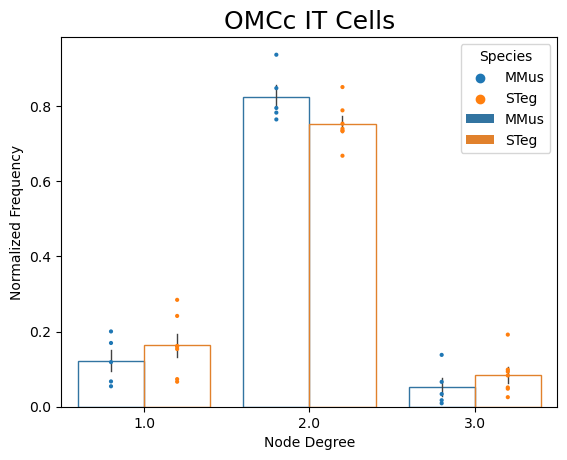

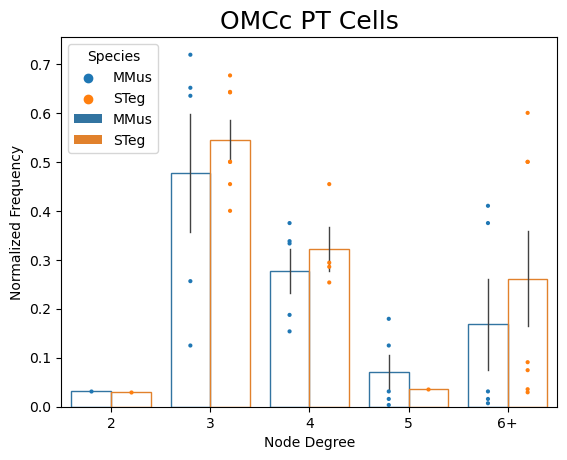

OMCi TO OMCc NEURONS


,Species,Mouse,OMCc neurons
0,STeg,STM1,11
1,STeg,STM2,2
2,STeg,STF3,2
3,STeg,STF4,28
4,STeg,STM5,5
5,STeg,STF6,67
6,STeg,STM7,34


,Species,Mouse,OMCc neurons
0,MMus,MMM1,8
1,MMus,MMF2,63
2,MMus,MMF3,32
3,MMus,MMM4,281
4,MMus,MMF5,39


In [26]:
# seperate OMCc neurons
omcc_it_mm = subset_neurons(omc_it_mm, area='OMCc')
omcc_it_st = subset_neurons(omc_it_st, area='OMCc')
omcc_pt_mm = subset_neurons(omc_pt_mm, area='OMCc')
omcc_pt_st = subset_neurons(omc_pt_st, area='OMCc')

# calculate degrees for omcc cells
omcc_mm_it_nodes = df_to_nodes(omcc_it_mm, drop=["OMCi"], mice=mice_mm, species="MMus")
omcc_st_it_nodes = df_to_nodes(omcc_it_st, drop=["OMCi"], mice=mice_st, species="STeg")
omcc_mm_pt_nodes = df_to_nodes(omcc_pt_mm, drop=["OMCi"], mice=mice_mm, species="MMus")
omcc_st_pt_nodes = df_to_nodes(omcc_pt_st, drop=["OMCi"], mice=mice_st, species="STeg")

omcc_mm_pt_nodes_5and = node_to_nand(omcc_mm_pt_nodes)
omcc_st_pt_nodes_5and = node_to_nand(omcc_st_pt_nodes)
plot = pd.concat([omcc_mm_it_nodes, omcc_st_it_nodes])
dot_bar_plot(plot, "OMCc IT Cells")
plot = pd.concat([omcc_mm_pt_nodes_5and, omcc_st_pt_nodes_5and])
dot_bar_plot(plot, "OMCc PT Cells")

print('OMCi TO OMCc NEURONS')
display(print_nums(omcc_pt_st, species='STeg', mice=mice_st, area="OMCc"))
display(print_nums(omcc_pt_mm, species='MMus', mice=mice_mm, area="OMCc"))


# SNr

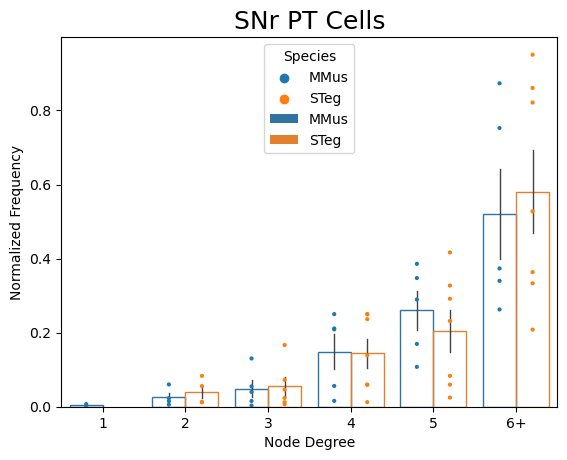

OMCi TO SNr NEURONS


,Species,Mouse,SNr neurons
0,STeg,STM1,55
1,STeg,STM2,12
2,STeg,STF3,24
3,STeg,STF4,108
4,STeg,STM5,81
5,STeg,STF6,84
6,STeg,STM7,151


,Species,Mouse,SNr neurons
0,MMus,MMM1,653
1,MMus,MMF2,1827
2,MMus,MMF3,656
3,MMus,MMM4,316
4,MMus,MMF5,1427


In [29]:
# seperate SNr neurons
snr_pt_mm = subset_neurons(omc_pt_mm, area='SNr')
snr_pt_st = subset_neurons(omc_pt_st, area='SNr')

# calculate degrees for snr cells
snr_mm_pt_nodes = df_to_nodes(snr_pt_mm, drop=["OMCi"], mice=mice_mm, species="MMus")
snr_st_pt_nodes = df_to_nodes(snr_pt_st, drop=["OMCi"], mice=mice_st, species="STeg")

snr_mm_pt_nodes_5and = node_to_nand(snr_mm_pt_nodes)
snr_st_pt_nodes_5and = node_to_nand(snr_st_pt_nodes)

plot = pd.concat([snr_mm_pt_nodes_5and, snr_st_pt_nodes_5and])
dot_bar_plot(plot, "SNr PT Cells")

print('OMCi TO SNr NEURONS')
display(print_nums(snr_pt_st, species='STeg', mice=mice_st, area='SNr'))
display(print_nums(snr_pt_mm, area='SNr'))

# probability testing

# expected: P(A) x P(B)


In [ ]:
def df_to_nodes(df_list, drop = ["OMCi", "type"], mice=None, species=None):
    """
    Function to turn list of binarized dataframes per animal to dataframe 
    containing node proportions

    df_list = list of binarized dataframes
    drop = list of column names to drop
    mice = list of mouse names
    species = string of species name
    returns dataframe of node proportions
    """

    nodes_list = []
    for i in range(len(df_list)):
        if drop == []:
            int_df = df_list[i]
        else:
            int_df = df_list[i].drop(drop, axis=1)
        nodes = int_df.sum(axis=1)
        node_counts = nodes.value_counts().sort_index()
        node_proportion = node_counts/node_counts.sum()
        df_save = pd.DataFrame(node_proportion, columns=["Normalized Frequency"]).reset_index(names="Node Degree")
        df_save["Species"] = species
        df_save["mouse"] = mice[i]
        nodes_list.append(df_save)

    node_all = pd.concat(nodes_list)

    return node_all

In [ ]:
def calc_axb(df_list, mice=None, species=None):
    exp_list = []
    for i in range(len(df_list)):
        df = df_list[i]
        df_prob = df.sum()/df.shape[0]
        exp_list.append(df_prob)
    return exp_list



In [33]:
aud_it_mm[0].sum()

OMCi    117.0
OMCc    105.0
AUD     117.0
STR     106.0
TH        0.0
HY        0.0
AMY       0.0
SNr       0.0
SCm       0.0
PG        0.0
PAG       0.0
BS        0.0
dtype: float64